
Estabelecendo conexão.

Iniciando coleta.

Fim da coleta.
media= 0.09

Período real: 0.02053269672393799


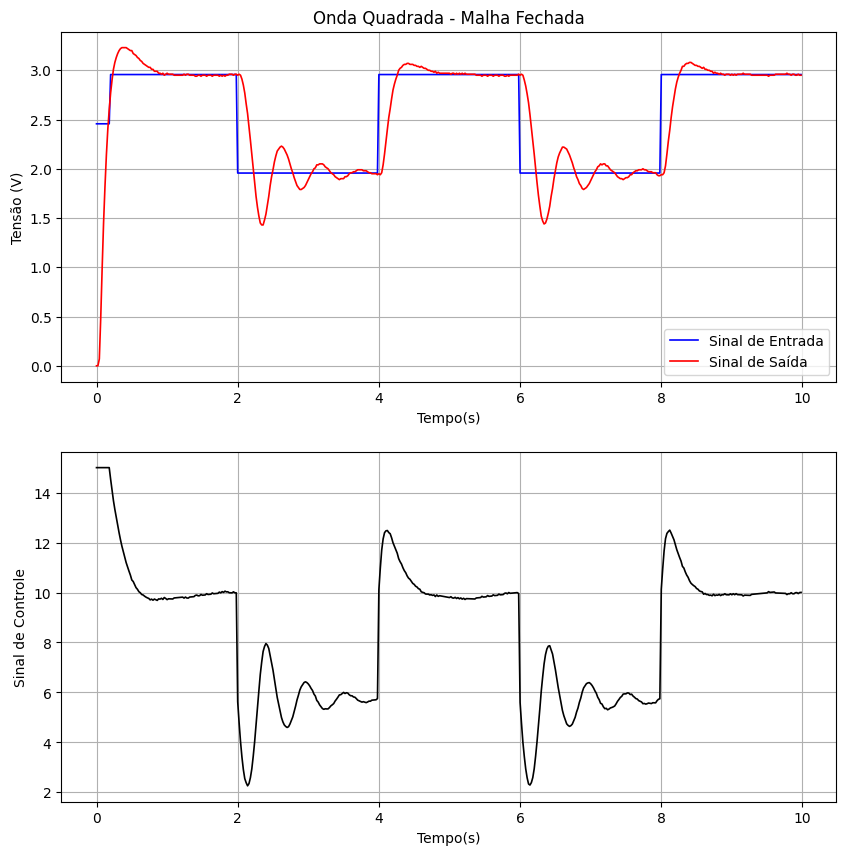

In [10]:
"""
Bancada Motor-Gerador
UFPA - Campus Tucuruí
Monitoria de Sistemas de Controle para Engenharia - PGRAD - MONITORIA 03/2020
Coodenador: Cleison Daniel Silva
Bolsista: Felipe Silveira Piano
Data: 27/09/2020
"""

import serial
import numpy as np
import matplotlib.pyplot as plt
import time as t
from scipy.signal import square,sawtooth


##########################################

tensao_alimentacao = 15

numAmostras = 500
tempo = np.zeros(numAmostras)
y = np.zeros(numAmostras)

Ts = 0.02

fre = 0.25
Amplitude = 0.5
setpoint = 0

nivel_dc_saida = 2.45682
nivel_dc_entrada = 7.5

# Kp = 0.120

r = np.zeros(numAmostras)
u = np.zeros(numAmostras)
erro = np.zeros(numAmostras)
u_sat = np.zeros(numAmostras)

toc = np.zeros(numAmostras)
######################


b0=4.4; b1=3.6

for n in range(numAmostras):
    r[n] = Amplitude*square(2*np.pi*fre*n*Ts) + setpoint
    #r[n] = Amplitude*sawtooth(2*np.pi*fre*n*Ts) + setpoint
    #r[n] = Amplitude*np.sin(2*np.pi*fre*n*Ts) + setpoint
    #r[n] = u[n]

print('\nEstabelecendo conexão.')
conexao = serial.Serial(port='COM3', baudrate=9600, timeout=0.005)

t.sleep(1)
print('\nIniciando coleta.')

for n in range(numAmostras):
    tic = t.time()

    if (conexao.inWaiting() > 0):
      y[n] = conexao.readline().decode()

    sinal_medido = y[n] - nivel_dc_saida
    erro[n] = r[n] - sinal_medido
    if (n<10):
        u[n] = nivel_dc_entrada
        r[n] = 0.0
    else:
        u[n] = ((u[n-1])+(b0*erro[n])-(b1*erro[n-1]))

    u_dc = u[n] + nivel_dc_entrada 

    if (u_dc>tensao_alimentacao):
        u_sat[n] = tensao_alimentacao
    else:
        u_sat[n] = u_dc 

    control = ((u_sat[n])*255)/tensao_alimentacao

    conexao.write(str(round(control)).encode())

    t.sleep(Ts)

    if (n > 0):
        tempo[n] = tempo[n-1] + Ts
    toc[n] = t.time() - tic
conexao.write('0'.encode())
print('\nFim da coleta.')
conexao.close()
print('media=',np.mean(r))

print('\nPeríodo real:', np.mean(toc))

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(tempo,r + nivel_dc_saida,'-b', tempo, y,'-r',linewidth=1.2)
plt.xlabel('Tempo(s)')
plt.ylabel('Tensão (V)')
# plt.xlim(2,10)
plt.grid()
plt.title('Onda Quadrada - Malha Fechada')
plt.legend(loc='lower right', labels=('Sinal de Entrada','Sinal de Saída'))

plt.subplot(212)
#plt.plot(tempo,r,'-b',tempo,y,'-r',linewidth=1.2)
plt.plot(tempo, u_sat,'-k',linewidth=1.2)
plt.xlabel('Tempo(s)')
plt.ylabel('Sinal de Controle')
# plt.xlim(2,10)
plt.grid()
# plt.title('Posição do sensor - Malha Aberta')
plt.show()

dados=np.stack((tempo,r,y,u_sat),axis=-1)
# np.save("C:/Users/leofr/OneDrive/Documentos/lab_de_controle/Nova pasta/Dados_Real_PRGBS_PI_NOVO.np", dados)